### Simulation: Masternode Yield Farming

In [1]:
import os
import copy
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import Image
cwd =  os.getcwd().replace("notebooks/research/impermanent_loss","")
os.chdir(cwd)

from python.dev.helper import Helper

from python.dev.simulation import SimulationOrchestrator
from python.dev.simulation import EventQueue
from python.dev.simulation import EventExecutor
from python.dev.simulation.batch import ActionBatch
from python.dev.simulation.batch import MergeBatch

from python.dev.agent import TokenAgent
from python.dev.agent import LPTokenAgent
from python.dev.agent import UserAgent

from python.dev.action import MintAction
from python.dev.action import DepositAction
from python.dev.action import LPDepositChainAction
from python.dev.action import DepositChainAction
from python.dev.action import WithdrawChainAction
from python.dev.action import WithdrawAction
from python.dev.action import SwapAction
from python.dev.event import Mint
from python.dev.event import Deposit
from python.dev.event import Withdraw
from python.dev.event import Swap

from python.dev.math.model import BrownianModel
from python.dev.math.model import TokenDeltaModel
from python.dev.math.model import TimeDeltaModel
from python.dev.math.model import ModelQueue

from python.dev.lp import LiquidityPool
from python.dev.lp.event import LPEvent
from python.dev.lp.event import MintLPEvent
from python.dev.lp.event import DepositLPEvent
from python.dev.lp.event import SwapLPEvent

In [2]:
from python.dev.cpt import Liquidity
import scipy.special as sps 

class SimulateLiquidity():
    
    def __init__(self, x_real, y_real, x_name, y_name, max_trade = 1000):       
        self.liq_obj = Liquidity(x_real, y_real, x_name, y_name)
        self.max_trade = max_trade
        self.shape = None
        self.scale = None

    def get_max_trade(self):
        return self.max_trade       
        
    def get_liquidity_obj(self):
        return self.liq_obj
        
    def set_params(self):
        self.shape, self.scale = 1, self.max_trade/5    
        
    def gen_delta_y(self):    
        self.set_params()
        return np.random.gamma(self.shape, self.scale)
    
    def gen_new_position(self, p):
        delta_y = self.gen_delta_y()
        delta_x = (self.liq_obj.get_y_real() + delta_y)/p - self.liq_obj.get_x_real()
        self.liq_obj.add_delta_y(delta_y)
        self.liq_obj.add_delta_x(delta_x)   
        
    def apply(self, p_arr):
        delta_x_arr = np.array([])
        delta_y_arr = np.array([])
        for p in p_arr: 
            self.gen_new_position(p)
            delta_x_arr = np.append(delta_x_arr,self.liq_obj.get_x_delta()) 
            delta_y_arr = np.append(delta_y_arr,self.liq_obj.get_y_delta()) 
            
        return delta_x_arr, delta_y_arr    

In [3]:
def gen_xy_value(p, x_mu_deposit, sigma=1):
    y_mu_deposit = p*x_mu_deposit
    #x_deposit_value = np.random.normal(x_mu_deposit, sigma)
    #y_withdraw_value = np.random.normal(y_mu_deposit, sigma)
    x_deposit_value = x_mu_deposit
    y_withdraw_value = y_mu_deposit    
    xy_values = np.array((x_deposit_value, y_withdraw_value))
    return xy_values


def gen_xy_arr(p_arr, x_mu_deposit=1, sigma=1):
    xy_vals_arr = np.array([])
    for p in p_arr:
        xy_vals = gen_xy_value(p, x_mu_deposit, sigma)
        if len(xy_vals_arr) == 0:
            xy_vals_arr = np.array(xy_vals) 
        else:
            xy_vals_arr = np.vstack((xy_vals_arr,xy_vals))
            
    return xy_vals_arr

### Initialize Agents

In [4]:
USER1 = UserAgent('USER1')
SYS = TokenAgent('SYS')
DAI = TokenAgent('DAI')
SYS_DAI_LP = LiquidityPool('SYS/DAI', USER1, SYS, DAI)
SYS_DAI = LPTokenAgent('SYS_DAI_LP', SYS_DAI_LP)

### Mint Tokens

In [5]:
apy = 0.1
t_delta = 109*24*3600
N_RUNS = 5*365

In [6]:
SYS_mint1 = Mint(5000000, apy, True)
DAI_mint1 = Mint(1000000, apy, True)
SYS_DAI_LP_mint1 = Mint(0, apy, True)

m_action1 = MintAction(SYS_mint1, SYS, USER1)
m_action2 = MintAction(DAI_mint1, DAI, USER1)
m_action3 = MintAction(SYS_DAI_LP_mint1, SYS_DAI, USER1)

In [7]:
sBatch = ActionBatch('SETUP1')
sBatch.init_action(m_action1)
sBatch.init_action(m_action2)
sBatch.init_action(m_action3)

setup_batch = sBatch.generate()

In [8]:
sBatch.inspect()

** SETUP1 INIT BATCH **
USER1 MINTs 5000000.00 SYS 
USER1 MINTs 1000000.00 DAI 
USER1 MINTs 0.00 SYS_DAI_LP 


### Setup Actions

### Batchset 2

In [9]:
t_delta_model = TimeDeltaModel().apply(p = 0.00001, n = N_RUNS)
t_delta_obj3 = ModelQueue().apply(t_delta_model)
t_delta_obj4 = ModelQueue().apply(t_delta_model)

In [10]:
N_RUNS = 1825

In [11]:
b = BrownianModel(0.2)
p_arr = b.gen_gbm(0.1, 1, N_RUNS, 1)
xy_arr = gen_xy_arr(p_arr, 100, 10)

sim_liq = SimulateLiquidity(1000, 200, 'SYS','DIA')
x_delta, y_delta = sim_liq.apply(p_arr)

r_deposit_model = np.random.normal(100, 10, N_RUNS)
r_withdraw_model = np.random.normal(20, 10, N_RUNS)

#r_deposit_model = np.abs(x_delta)
#r_withdraw_model = y_delta

In [12]:
#r_deposit_model = x_delta[:10]
#r_withdraw_model = y_delta[:10]

In [13]:
r_withdraw_obj1 = ModelQueue().apply(r_deposit_model)
r_withdraw_obj2 = ModelQueue().apply(r_deposit_model)

In [14]:
#deposit_event1 = Deposit(apy, r_deposit_obj1, t_delta_obj3) 
#deposit_event2 = Deposit(apy, r_deposit_obj2, t_delta_obj4) 

withdraw_event1 = Withdraw(apy, r_withdraw_obj1, t_delta_obj3) 
withdraw_event2 = Withdraw(apy, r_withdraw_obj2, t_delta_obj4) 

In [15]:
# Deposit SYS
#d_action1 = DepositAction(deposit_event1, SYS, USER1, SYS_mint1.get_id())
#d_action2 = DepositAction(deposit_event2, DAI, USER1, DAI_mint1.get_id())

w_action1 = WithdrawAction(withdraw_event1, SYS, USER1, SYS_mint1.get_id())
w_action2 = WithdrawAction(withdraw_event2, DAI, USER1, DAI_mint1.get_id())

d_action3 = LPDepositChainAction(w_action1, w_action2, SYS_DAI, USER1, SYS_DAI_LP_mint1.get_id())



In [16]:
aBatch = ActionBatch('RUN1', N_RUNS)
aBatch.add_action(w_action1)
aBatch.add_action(w_action2)
aBatch.add_action(d_action3)
action_batch = aBatch.generate()

In [17]:
#aBatch.inspect()


### Setup event queue

In [18]:
q = EventQueue()
q.add_setup_batch(setup_batch)
q.add_action_batch(action_batch)
q.freeze()

### Execute events

In [19]:
all_batches = q.get_all_batches()

orchestrator = SimulationOrchestrator(verbose = False)
executor = EventExecutor(q, orchestrator)
executor.run()

In [20]:
#orchestrator.print_logs()

### Analyze

In [21]:
tSYS = SYS.get_token()
tDAI = DAI.get_token()
tSYS_DAI = SYS_DAI.get_token()

SYS_addr1 = SYS.get_address(SYS_mint1.get_id())
DAI_addr1 = DAI.get_address(DAI_mint1.get_id())
SYS_DAI_addr1 = SYS_DAI.get_address(SYS_DAI_LP_mint1.get_id())

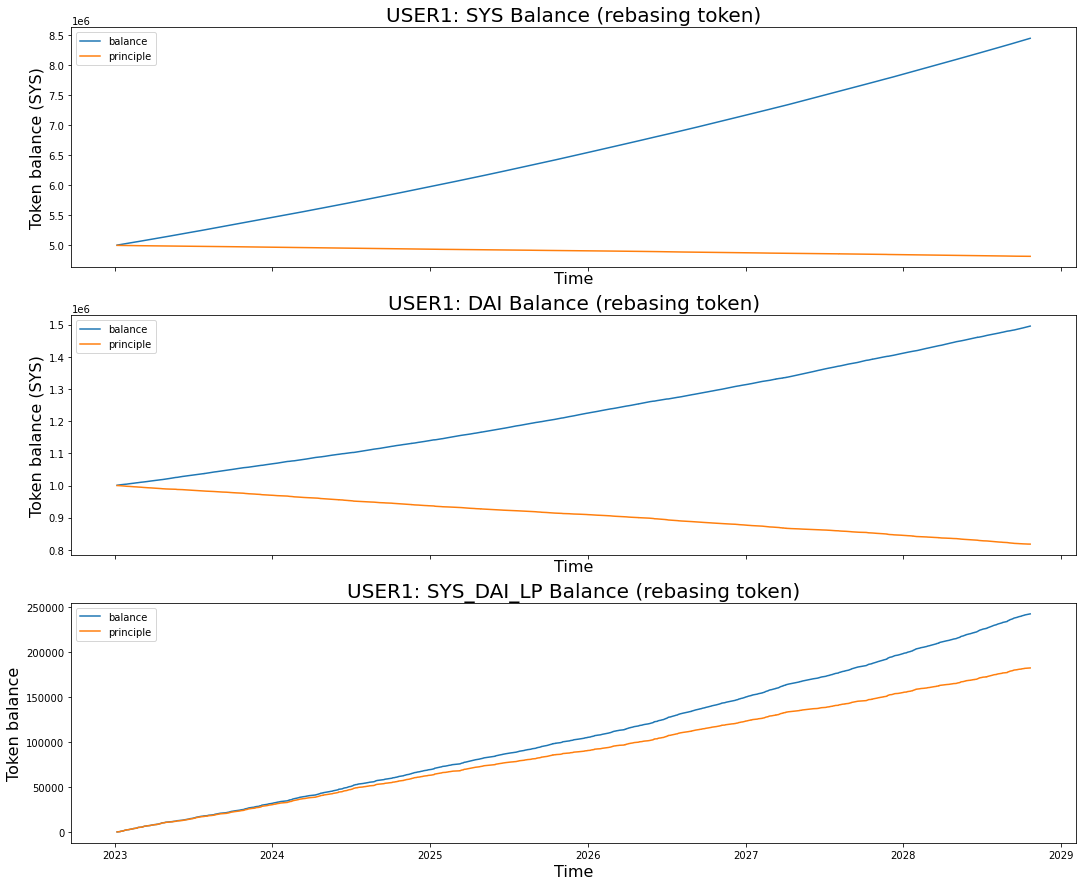

In [22]:
SYS_states1 = tSYS.get_state_series(SYS_addr1)
principle = SYS_states1.get_principle() 
balance = SYS_states1.get_balance() 
tSamp = SYS_states1.get_tstamp()  

fig, (SYS_ax, DAI_ax, SYS_DAI_ax) = plt.subplots(nrows=3, sharex=True, sharey=False, figsize=(18, 15))

SYS_ax.plot(tSamp[1:], balance[1:], label='balance') 
SYS_ax.plot(tSamp[1:], principle[1:], label='principle') 
SYS_ax.set_title("USER1: SYS Balance (rebasing token)", fontsize=20)
SYS_ax.set_ylabel("Token balance (SYS)", fontsize=16)
SYS_ax.set_xlabel('Time', fontsize=16)
SYS_ax.legend()

DAI_states1 = tDAI.get_state_series(DAI_addr1)
principle = DAI_states1.get_principle() 
balance = DAI_states1.get_balance() 
tSamp = DAI_states1.get_tstamp() 

DAI_ax.plot(tSamp[1:], balance[1:], label='balance') 
DAI_ax.plot(tSamp[1:], principle[1:], label='principle') 
DAI_ax.set_title("USER1: DAI Balance (rebasing token)", fontsize=20)
DAI_ax.set_ylabel("Token balance (SYS)", fontsize=16)
DAI_ax.set_xlabel('Time', fontsize=16)
DAI_ax.legend()

SYS_DAI_states1 = tSYS_DAI.get_state_series(SYS_DAI_addr1)
principle = SYS_DAI_states1.get_principle() 
balance = SYS_DAI_states1.get_balance() 
tSamp = SYS_DAI_states1.get_tstamp() 

principle1 = principle
tSamp1 = tSamp

SYS_DAI_ax.plot(tSamp[1:], balance[1:], label='balance') 
SYS_DAI_ax.plot(tSamp[1:], principle[1:], label='principle') 
SYS_DAI_ax.set_title("USER1: SYS_DAI_LP Balance (rebasing token)", fontsize=20)
SYS_DAI_ax.set_ylabel("Token balance", fontsize=16)
SYS_DAI_ax.set_xlabel('Time', fontsize=16)
SYS_DAI_ax.legend()

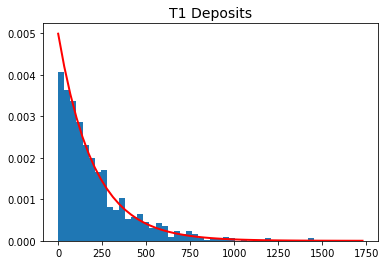

In [23]:
import scipy.special as sps 
max_trade = 1000
shape, scale = 1, max_trade/5  
s = np.random.gamma(shape, scale, 1000)

count, bins, ignored = plt.hist(s, 50, density=True)
y = bins**(shape-1)*(np.exp(-bins/scale) /  
                     (sps.gamma(shape)*scale**shape))
plt.plot(bins, y, linewidth=2, color='r')  
plt.title("T1 Deposits", fontsize=14)
plt.show()

In [24]:
np.random.gamma(shape, scale)

373.74955488460574

In [25]:
from python.dev.cpt import Liquidity

In [26]:
liq = Liquidity(100, 20, 'SYS','DIA')

In [27]:
liq.get_price()

0.19999999999999998

In [28]:
liq.get_y_real()

20

In [29]:
liq.get_x_real()

100

In [30]:
p_arr[1]*liq.get_x_real()

19.722764299414237

In [31]:
p_arr[0:5]

array([0.2       , 0.19722764, 0.2003673 , 0.20288205, 0.20229683])

In [32]:
class SimulateLiquidity():
    
    def __init__(self, x_real, y_real, x_name, y_name, max_trade = 1000):       
        self.liq_obj = Liquidity(x_real, y_real, x_name, y_name)
        self.max_trade = max_trade
        self.real_x_arr = np.array([])
        self.real_y_arr = np.array([])        
        self.shape = None
        self.scale = None

    def get_max_trade(self):
        return self.max_trade       
        
    def get_liquidity_obj(self):
        return self.liq_obj
    
    def get_real_x(self):
        return self.real_x_arr
    
    def get_real_y(self):
        return self.real_y_arr    
        
    def set_params(self):
        self.shape, self.scale = 1, self.max_trade/5    
 
    def gen_delta_x(self, p):    
        self.set_params()
        return np.random.gamma(self.shape, self.scale)/p

    def gen_delta_y(self):    
        self.set_params()
        return np.random.gamma(self.shape, self.scale)
    
    def gen_new_position(self, p):
        delta_y = self.gen_delta_y()
        delta_x = (self.liq_obj.get_y_real() + delta_y)/p - self.liq_obj.get_x_real()
        self.liq_obj.add_delta_y(delta_y)
        self.liq_obj.add_delta_x(delta_x)   
        
    def apply(self, p_arr):
        delta_x_arr = np.array([])
        delta_y_arr = np.array([])
        for p in p_arr: 
            self.gen_new_position(p)
            delta_x_arr = np.append(delta_x_arr,self.liq_obj.get_x_delta()) 
            delta_y_arr = np.append(delta_y_arr,self.liq_obj.get_y_delta()) 
            self.real_x_arr = np.append(self.real_x_arr,self.liq_obj.get_x_real()) 
            self.real_y_arr = np.append(self.real_y_arr,self.liq_obj.get_y_real()) 
            
        return delta_x_arr, delta_y_arr    

In [33]:
b = BrownianModel(0.2)
p_arr = b.gen_gbm(0.1, 1, N_RUNS, 1)

sim_liq = SimulateLiquidity(1000, 200, 'SYS','DIA')
x_delta, y_delta = sim_liq.apply(p_arr)

liq = sim_liq.get_liquidity_obj()
liq.get_price()

1.0043045177544896

In [34]:
(p_arr[1]-p_arr[0])/p_arr[0]

0.060192599316411244

In [35]:
def calc_delta_y(x,y,dx,dp):
    return (dp*x**2 + dp*dx*x + dx*y)/x

def calc_delta_x(x,y,dy,dp):
    return (dy*x-dp*x**2)/(dp*x+y)

In [36]:
from scipy.optimize import fsolve

In [55]:
p = 0.2
x = 10000; dx = -36.4955
y = 2000; dy = 20
dp = 0.20273991-0.2

class SolveDeltas():
    
    def __init__(self, x, y, prev_p):
        self.x = x
        self.y = y
        self.prev_p = prev_p
        self.dx = None
        self.dy = None
        self.dp = None
        self.p = None
        self.dp_arr = np.array([])
        self.dx_arr = np.array([])
        self.dy_arr = np.array([])
        self.x_arr = np.array([x])
        self.y_arr = np.array([y])
        
    def apply(self, p):
        
        self.dx, self.dy = self.calc_dx_dy(p)
        self.check(p)
        self.x = self.x + self.dx
        self.y = self.y + self.dy
        self.prev_p = p
        #self.check(p)
        self.update(p)
    
    def check(self,p):
        prev_price = self.prev_p
        dp = self.calc_dp(self.dx, self.dy)
        new_price = self.prev_p+dp
        self.dp_arr = np.append(self.dp_arr,dp)
        print('prev: {:.5f} calc: {:.5f} '.format(prev_price, new_price))
        
    def update(self, p):  
        self.x_arr = np.append(self.x_arr,self.x)
        self.y_arr = np.append(self.y_arr,self.y)
        self.dx_arr = np.append(self.dx_arr,self.dx)
        self.dy_arr = np.append(self.dy_arr,self.dy)
        
    def get_dx(self):
        return self.dx
    
    def get_dy(self):
        return self.dy    
    
    def get_y(self):
        return self.y     
    
    def get_x(self):
        return self.x   
    
    def get_dx_arr(self):
        return self.dx_arr
    
    def get_dy_arr(self):
        return self.dy_arr    
    
    def get_y_arr(self):
        return self.y_arr     
    
    def get_x_arr(self):
        return self.x_arr 
    
    def get_dp_arr(self):
        return self.dp_arr    
            
        
    def func_swap_yx(self, z):
        return [(self.x*abs(z[1]) + abs(z[0])*self.y)/(self.x**2 - abs(z[0])*self.x) - self.dp,
                abs(z[1])/abs(z[0]) - self.p]

    def func_swap_xy(self, z):
        return [-(self.x*abs(z[1]) + abs(z[0])*self.y)/(self.x**2 + abs(z[0])*self.x) - self.dp,
                abs(z[1])/abs(z[0]) - self.p]

    def calc_dx_dy(self, p):
        self.p = p
        self.dp = self.p - self.prev_p
        if(self.dp >= 0):
            dx, dy = fsolve(self.func_swap_yx, [1, 1])
            return -dx, dy
        else:
            dx, dy = fsolve(self.func_swap_xy, [1, 1])
            return dx, -dy 

    def calc_dp(self, dx, dy):
        return (self.x*dy - dx*self.y)/(self.x**2 +dx*self.x)    
           
#dx, dy = calc_dx_dy(dp)
#dx, dy = root
#print(p+calc_dp(dx, dy))
#dx, dy

In [53]:
dDel = SolveDeltas(10000,2000,0.2)
dDel.apply(0.20273991)

dx = dDel.get_dx()
dy = dDel.get_dy()

#print(p+calc_dp(dx, dy))
print('{} {}'.format(dx,dy))

prev: 0.20000 calc: 0.20274 
-67.57204341266565 13.699549999999915


In [54]:
dDel = SolveDeltas(10000,2000,0.2)
dDel.apply(0.19082766)

dx = dDel.get_dx()
dy = dDel.get_dy()

#print(p+calc_dp(dx, dy))
print('{} {}'.format(dx,dy))

prev: 0.20000 calc: 0.19083 
240.33046362350038 -45.86170000001258


In [40]:
p = 0.2
x = 10000; dx = -36.4955
y = 2000; dy = 20
dp = 0.19082766-0.2

#dx, dy = calc_dx_dy(dp)
#print(p+calc_dp(dx, dy))
#dx, dy

In [41]:
dDel.calc_dp(dx, dy)

0.00264257026516574

In [42]:
dDel = SolveDeltas(10000,2000,0.2)
dDel.apply(p_arr[1])

dDel.get_dx(), dDel.get_dy()

prev: 0.20000 calc: 0.21204 


(-283.875775756782, 60.19259931631617)

In [43]:
p_arr[1:10]

array([0.21203852, 0.2098561 , 0.20692748, 0.21200795, 0.20877234,
       0.21142422, 0.2186088 , 0.22099243, 0.22007477])

In [51]:
dDel = SolveDeltas(10000,2000,0.2)

for p in p_arr[1:100]:
    dDel.apply(p)

prev: 0.20000 calc: 0.21204 
prev: 0.21204 calc: 0.20986 
prev: 0.20986 calc: 0.20693 
prev: 0.20693 calc: 0.21201 
prev: 0.21201 calc: 0.20877 
prev: 0.20877 calc: 0.21142 
prev: 0.21142 calc: 0.21861 
prev: 0.21861 calc: 0.22099 
prev: 0.22099 calc: 0.22007 
prev: 0.22007 calc: 0.21750 
prev: 0.21750 calc: 0.21297 
prev: 0.21297 calc: 0.21768 
prev: 0.21768 calc: 0.21202 
prev: 0.21202 calc: 0.21397 
prev: 0.21397 calc: 0.21654 
prev: 0.21654 calc: 0.22283 
prev: 0.22283 calc: 0.21928 
prev: 0.21928 calc: 0.21418 
prev: 0.21418 calc: 0.21296 
prev: 0.21296 calc: 0.21462 
prev: 0.21462 calc: 0.21088 
prev: 0.21088 calc: 0.20713 
prev: 0.20713 calc: 0.20853 
prev: 0.20853 calc: 0.20822 
prev: 0.20822 calc: 0.21174 
prev: 0.21174 calc: 0.21030 
prev: 0.21030 calc: 0.21830 
prev: 0.21830 calc: 0.22389 
prev: 0.22389 calc: 0.22344 
prev: 0.22344 calc: 0.21713 
prev: 0.21713 calc: 0.21802 
prev: 0.21802 calc: 0.21471 
prev: 0.21471 calc: 0.21234 
prev: 0.21234 calc: 0.21644 
prev: 0.21644 

In [49]:
p_arr[1:100] - p_arr[:99]

array([ 1.20385199e-02, -2.18242446e-03, -2.92861952e-03,  5.08047409e-03,
       -3.23561102e-03,  2.65188083e-03,  7.18458179e-03,  2.38362373e-03,
       -9.17658793e-04, -2.57752851e-03, -4.52533323e-03,  4.70605222e-03,
       -5.65411650e-03,  1.95015138e-03,  2.56390830e-03,  6.29407262e-03,
       -3.55649117e-03, -5.09653524e-03, -1.21727269e-03,  1.65879033e-03,
       -3.74342094e-03, -3.74228340e-03,  1.39029545e-03, -3.06000253e-04,
        3.51684461e-03, -1.43965735e-03,  8.00638144e-03,  5.58614860e-03,
       -4.51218676e-04, -6.30553612e-03,  8.92908889e-04, -3.31248888e-03,
       -2.36876109e-03,  4.10074331e-03, -2.58369423e-03, -1.69605303e-03,
        6.44616835e-03, -6.90866514e-03,  3.42753786e-03,  4.45276618e-03,
       -3.83718252e-03, -2.25482591e-03,  9.00039581e-03, -2.65215316e-03,
        3.82731426e-03,  9.61184732e-03,  6.21520514e-03,  5.70376825e-03,
       -5.75116902e-03, -3.88690591e-03, -7.71858211e-03,  1.49444365e-03,
        2.82290235e-03,  

In [50]:
dDel.get_dp_arr()

array([ 1.20385199e-02, -2.18242446e-03, -2.92861952e-03,  5.08047409e-03,
       -3.23561102e-03,  2.65188083e-03,  7.18458179e-03,  2.38362373e-03,
       -9.17658793e-04, -2.57752851e-03, -4.52533323e-03,  4.70605222e-03,
       -5.65411650e-03,  1.95015138e-03,  2.56390830e-03,  6.29407262e-03,
       -3.55649117e-03, -5.09653524e-03, -1.21727269e-03,  1.65879033e-03,
       -3.74342094e-03, -3.74228340e-03,  1.39029545e-03, -3.06000253e-04,
        3.51684461e-03, -1.43965735e-03,  8.00638144e-03,  5.58614860e-03,
       -4.51218676e-04, -6.30553612e-03,  8.92908889e-04, -3.31248888e-03,
       -2.36876109e-03,  4.10074331e-03, -2.58369423e-03, -1.69605303e-03,
        6.44616835e-03, -6.90866514e-03,  3.42753786e-03,  4.45276618e-03,
       -3.83718252e-03, -2.25482591e-03,  9.00039581e-03, -2.65215316e-03,
        3.82731426e-03,  9.61184732e-03,  6.21520514e-03,  5.70376825e-03,
       -5.75116902e-03, -3.88690591e-03, -7.71858211e-03,  1.49444365e-03,
        2.82290235e-03,  

In [47]:
p = 0.2
#p = 0.20273991
x = 10000; dx = -36.4955
y = 2000; dy = 20
dp = 0.19082766-0.2

from scipy.optimize import fsolve

def swap_xy(x,y,dp):
    root = fsolve(func_swap_xy, [1, 1])
    return dx, dy 


dx, dy = calc_dx_dy(dp)
print(p+calc_dp(dx, dy))
dx, dy

NameError: name 'calc_dx_dy' is not defined

In [ ]:
dDel = SolveDeltas(10000,2000,0.2)
dDel.apply(0.19082766)

dx = dDel.get_dx()
dy = dDel.get_dy()

print(p+calc_dp(dx, dy))
print('{} {}'.format(dx,dy))

In [ ]:
def calc_dp(dx, dy):
    return (x*dy - dx*y)/(x**2 +dx*x)

In [ ]:
z = [dx,dy]
z = root
(x*dy - dx*y)/(x**2 + dx*x) - dp

z[1]/z[0] - p

In [ ]:
from scipy.optimize import fsolve
def func_swap_yx(z):
    return [(x*abs(z[1]) + abs(z[0])*y)/(x**2 - abs(z[0])*x) - dp,
            abs(z[1])/abs(z[0]) - p]
root = fsolve(func_swap_yx, [1, 1])
dx, dy = root
root

In [ ]:
(x*dy + dx*y)/(x**2 - dx*x) - dp

In [ ]:
dy/dx 

In [ ]:
calc_delta_x(x,y,dy,dp)

In [ ]:
calc_delta_y(x,y,dx,dp)

In [ ]:
import numpy as np
from scipy.optimize import minimize

p = 0.2
#p = 0.20273991
#dx = -36.4955; dy = 20
x = 1000; y = 200
dp = 0.20273991-0.2


def my_fun(z):
    dx = z[0]
    dy = z[1]

    f = np.zeros(2)
    #f[0] = (x*dy - dx*y)/(x**2 + dx*x) - dp
    f[0] = (x*dy + dx*y)/(x**2 - dx*x) - dp
    f[1] = dy/dx - p
    return np.abs(f[0]+f[1])

def my_cons(z):
    dx = z[0]
    dy = z[1]
    f = np.zeros(2)
    f[0] = dx
    f[1] = dy
    return f

cons = {'type' : 'ineq', 'fun': my_cons}
res = minimize(my_fun, (1, 1), method='SLSQP',constraints=cons,tol=1e-12)
dx, dy = res['x']
res

In [ ]:
my_fun(res['x'])

In [ ]:
(x*dy - dx*y)/(x**2 + dx*x) - dp

In [ ]:
dy/dx 

In [ ]:
(x*dy - dx*y)/(x**2 + dx*x) - dp

In [ ]:
(x*dy - dx*y)/(x**2 + dx*x) - dp

In [ ]:
b = BrownianModel(0.2)
p_arr = b.gen_gbm(0.1, 1, N_RUNS, 1)
dp_arr  = np.diff(p_arr)
increase_y = dp_arr > 0

* https://stackoverflow.com/questions/30378861/scipy-non-linear-equations-system-with-linear-constraints-beginner

In [ ]:
def gen_delta_y(max_trade = 10):    
    shape, scale = 1, max_trade/5 
    return np.random.gamma(shape, scale)
    #return 100

def gen_delta_x(p, max_trade = 10):    
    shape, scale = 1, max_trade/5 
    return np.random.gamma(shape, scale)/p
    #return 100/p
    
def per_chg(p_arr, k):
    return (p_arr[k]-p_arr[k-1])/p_arr[k-1]



print(p_arr[0:5])

liq_obj = Liquidity(10000, 2000, 'SYS','DIA')
x_arr = np.array([])
y_arr = np.array([])
x_delta_arr = np.array([])
y_delta_arr = np.array([])

for k in range(1,len(p_arr)):
    p = p_arr[k]
    inc = increase_y[k-1]
    x = liq_obj.get_x_real()
    y = liq_obj.get_y_real()
    dp = dp_arr[k-1]
    if(increase_y[k-1]):
        #delta_y = gen_delta_y()
        #delta_x = (liq_obj.get_y_real() + delta_y)/p - liq_obj.get_x_real()
        dy = 0.01*y
        dx = calc_delta_x(x,y,dy,dp)      
    else:    
        #delta_x = gen_delta_x(p)
        #delta_y = p*delta_x + p*liq_obj.get_x_real() - liq_obj.get_y_real() 
        dx = 0.01*x
        dy = calc_delta_y(x,y,dx,dp)
    
    liq_obj.add_delta_y(dy)
    liq_obj.add_delta_x(dx)  
    x_real = liq_obj.get_x_real()
    y_real = liq_obj.get_y_real()
    
    x_arr = np.append(x_arr, x_real)
    y_arr = np.append(y_arr, y_real)
    x_delta_arr = np.append(x_delta_arr, dx)
    y_delta_arr = np.append(y_delta_arr, dy)    

    print('[inc y: {}],   \u0394y {:.2f}, \u0394x {:.2f}'.format(inc, dy, dx))
    print('[p:     {:.4f}]   y {:.2f},  x {:.2f}\n'.format(y_real/x_real, y_real, x_real))
    


In [ ]:
x_real = sim_liq.get_real_x()
y_real = sim_liq.get_real_y()

fig, (p_ax, liq_ax, d_ax) = plt.subplots(nrows=3, sharex=False, sharey=False, figsize=(18, 15))

p_ax.plot(p_arr, label='SYS/DAI') 
p_ax.set_title("Price", fontsize=20)
p_ax.set_xlabel('Time', fontsize=16)
p_ax.legend()

liq_ax.plot(x_arr, label='SYS') 
liq_ax.plot(y_arr, label='DIA') 
liq_ax.set_title("Token balances", fontsize=20)
liq_ax.set_xlabel('Time', fontsize=16)
liq_ax.legend()

d_ax.plot(x_delta_arr, label='SYS_delta') 
d_ax.plot(y_delta_arr, label='DIA_delta') 
d_ax.set_title("Price", fontsize=20)
d_ax.set_xlabel('Time', fontsize=16)
d_ax.legend()

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.neighbors import KernelDensity

class KDE():
    
    def __init__(self, kernel='gaussian'):
        self.__kernel = kernel
        self.__kde = None
        self.__samp = None

    def fit(self, y_arr, bw=0.01):
        self.__samp = y_arr
        self.__kde = KernelDensity(bandwidth=bw, kernel = self.__kernel)
        self.__kde.fit(self.__samp.reshape([-1,1]))           
        
    def sample(self, N):
        eval_pnts = np.linspace(np.min(self.__samp), np.max(self.__samp))
        return eval_pnts, self.__kde.sample(N)  
    
    def get_pdf_est(self):
        eval_pnts = np.linspace(np.min(self.__samp), np.max(self.__samp))
        return np.exp(self.__kde.score_samples(eval_pnts.reshape(-1,1)))    
        
    def get_kde(self):
        return self.__kde

In [ ]:
kde_x = KDE()
xfit = kde_x.fit(x_delta_arr, bw=40)

kde_y = KDE()
yfit = kde_y.fit(y_delta_arr, bw=40)

y_kde_est = kde_y.get_pdf_est()
y_pnts, y_kde_samp = kde_y.sample(1000)

x_kde_est = kde_x.get_pdf_est()
x_pnts, x_kde_samp = kde_x.sample(1000)

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(15, 10))
ax1.plot(y_pnts, y_kde_est, c='g')
ax1.hist(y_kde_samp, bins=100, density=True, color='r', alpha=0.7)

ax2.plot(x_pnts, x_kde_est, c='g')
ax2.hist(x_kde_samp, bins=100, density=True, color='r', alpha=0.7)

plt.show()

In [ ]:
x = np.array([])
x = np.append(x,1)
x

In [ ]:
sim_liq = SimulateLiquidity(1000, 200, 'SYS','DIA')

liq = sim_liq.get_liquidity_obj()
liq.calc()
liq.get_price()

In [ ]:
liq = Liquidity(1000, 200, 'SYS','DIA')

In [ ]:
delta_y = np.random.gamma(shape, scale)
delta_x = (liq.get_y_real() + delta_y)/p_arr[1] - liq.get_x_real()
liq.add_delta_y(delta_y)
liq.add_delta_x(delta_x)
#liq.calc()
#liq.get_price()

In [ ]:
delta_y = np.random.gamma(shape, scale)
delta_x = (liq.get_y_real() + delta_y)/p_arr[2] - liq.get_x_real()
liq.add_delta_y(delta_y)
liq.add_delta_x(delta_x)
#liq.calc()
#liq.get_price()

In [ ]:
delta_y = np.random.gamma(shape, scale)
delta_x = (liq.get_y_real() + delta_y)/p_arr[3] - liq.get_x_real()
liq.add_delta_y(delta_y)
liq.add_delta_x(delta_x)
liq.calc()
liq.get_price()

In [ ]:
liq.get_x_real()

In [ ]:
liq.get_y_real()

In [ ]:
liq.get_price()

In [ ]:
liq.add_delta_y(delta_y)
liq.add_delta_x(delta_x)
liq.calc()
liq.get_price()

In [ ]:
liq.get_x_real()

In [ ]:
y_new = 10

(liq.get_x_real()*y_new)/(liq.get_y_real()+y_new)


In [ ]:
30/133

In [ ]:
liq.get_y_real()

In [ ]:
liq = Liquidity(100, 20, 'SYS','DIA')

In [ ]:
delta_y = (p_arr[1]-p_arr[0])*liq.get_x_real() 
liq.add_delta_y(delta_y)
liq.calc()
liq.get_price()

In [ ]:
liq.get_x_real()

In [ ]:
delta_y = (p_arr[2]-p_arr[1])*liq.get_x_real()
liq.add_delta_y(delta_y)
liq.calc()
liq.get_price()

In [ ]:
delta_y = (p_arr[3]-p_arr[2])*liq.get_x_real()
liq.add_delta_y(delta_y)
liq.calc()
liq.get_price()

In [ ]:
liq.get_y_real()

In [ ]:
liq.get_x_real()

In [ ]:
p_arr[0:5]

In [ ]:
#SYS_DAI_LP_prices[1:]

In [ ]:
SYS_DAI_LP = SYS_DAI.get_lp().get_lp_events()
SYS_DAI_LP_prices = SYS_DAI_LP.get_prices()
SYS_DAI_LP_dates = SYS_DAI_LP.get_dates()

fig, (SYS_DAI_ax) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(18, 5))
SYS_DAI_ax.plot(SYS_DAI_LP_dates[1:], 1/SYS_DAI_LP_prices[1:], label='prices') 
SYS_DAI_ax.plot(SYS_DAI_LP_dates[1:], p_arr[2:], color = 'r', label='prices') 

SYS_DAI_ax.set_title("USER1: SYS_DAI_LP Prices (rebasing token)", fontsize=20)
SYS_DAI_ax.set_ylabel("SYS / DIA", fontsize=16)
SYS_DAI_ax.set_xlabel('Time', fontsize=16)
SYS_DAI_ax.legend()

In [ ]:
#orchestrator.print_logs()

In [ ]:
SYS_DAI_LP.get_event(1).get_liquidity().get_y_real()

In [ ]:
SYS_DAI_LP.get_event(1).get_liquidity().get_x_real()

In [ ]:
SYS_DAI_LP.get_event(1).get_liquidity().get_price()

In [ ]:
SYS_DAI_LP.get_event(3).get_liquidity().get_liquidity_val()

In [ ]:
#b = BrownianModel(0.2)
#p_arr = b.gen_gbm(0.1, 1, 365, 1)
#xy_arr = gen_xy_arr(p_arr, 100)